## Using the PennyLane QAOA Module

In [1]:
import pennylane as qml
from pennylane import qaoa
import numpy as np
from matplotlib import pyplot as plt
import networkx as nx

#### Introduction: Useful PennyLane Functionality

The goal of the PennyLane library is to provide users with a wide range of easy-to-use, general functions

**1. Adding, Subtracting, and Multiplying Observables**

At a fundamental level, a quantum circuit is simply a state vector, multiplied by a series of quantum operations, followed by measurement with respect to some observable quantity. Oftentimes, these observable quantities that we wish to measure are simply one-qubit operations, like the Pauli-$Z$ and Pauli-$X$. In other cases, especially in variational algorithms like VQE and QAOA, we have to measure the expectation value of much more complicated observables called **Hamiltonians**. These Hamiltonians are often times linear combinations of many tensor products of one-qubit operations. For example, this is the Hamiltonian of which we calculate the expectation value when performing VQE for the $H2$ molecule:

<center>
    <figure>
    <img src="assets/hamiltonian.png" style="height:125px;">
    </figure>
</center>

Since Hamiltonians are often very complicated, we introduce PennyLane functionality that allows the use of arithmetic operations between observables, tensor products of observables, and ``pennylane.Hamiltonian`` objects (linear combinations of observables/tensors of observables). For example, if we wish to define the following Hamiltonian:

$$H \ = \ 3 Z_{0} Z_{1} \ + \ 0.2 Z_{0} \ + \ 4 X_{2} \ + \ 1.2 Y_{0} X_{2}$$

this can easily be done using PennyLane:

In [2]:
H = 3 * (qml.PauliZ(0) @ qml.PauliZ(1)) + 0.2 * qml.PauliZ(0) + 4 * qml.PauliX(2) + 1.2 * (qml.PauliY(0) @ qml.PauliX(2))
print(H)

(3) [Z0 Z1]
+ (0.2) [Z0]
+ (4) [X2]
+ (1.2) [Y0 X2]


We can also use arithmetic operations between Hamiltonians, and other combinations of observables:

In [4]:
H1 = qml.Hamiltonian([1, 1], [qml.PauliX(0), qml.PauliX(1)])
H2 = qml.Hamiltonian([1, 1], [qml.PauliX(1), qml.PauliX(2)])
term = 3 * qml.PauliZ(0) @ qml.PauliZ(1)

H = H1 + H2 - term
print(H)

(1) [X0]
+ (2) [X1]
+ (1) [X2]
+ (-3) [Z0 Z1]


This feature will prove to be useful in a variety of situations, including when defining cost and mixer Hamiltonians to use in QAOA.

**2. Defining circuits in terms of Hamiltonians.**

Oftentimes, when considering thinking of quantum circuits or variational ansatzae, it is convenient to consider these processes as defined by a series of quantum gates. However, as it turns out, there are many instances where it is useful to think of a quantum circuit in terms of a *Hamiltonian*. For instance, in quantum mechanics, a unitary transformation of great interest is that of time-evolution:

$$U \ = \ e^{-i \hat{H} t / \hbar}$$

This unitary is clearly defined completely in terms of a Hamiltonian, $\hat{H}$ and a scalar $t$. Mimicing the general form of the time-evolution unitary, as it is the most general example of a unitary determined by a Hamiltonian, we define a time-evolution template in PennyLane, more specifically, an *approximate* time-evolution template, which implements a unitary of the form:

$$U(\hat{H}, t, n) \ = \ \displaystyle\prod_{j \ = \ 1}^{n} \displaystyle\prod_{k} e^{-i \hat{H}_k t}$$

where:

$$\hat{H} \ = \ \displaystyle\sum_{k} \hat{H}_k$$

**3. Repeating/layering quantum circuits.**

Another fundamental idea within quantum computation is repetedly applictions of quantum gates. This can be seen everywhere, from amplitude amplification in Grover's algorithm and HHL, to layers in quantum neural networks, to Trotterization in quantum simulation. 

<center>
    <figure>
    <img src="assets/repeat.png" style="height:400px;">
    </figure>
</center>

We therefore define the ``qml.layer`` method in PennyLane to alternate an arbitrary unitary. This general method allows us to take a function containing quantum operations, a template, or even a single quantum gate and repeatedly apply it. For example, consider the following complicated

<center>
    <figure>
        <img src="assets/qml_layer.png" style="height:200px;margin-left:-100px;">
    </figure>
</center>

### The Quantum Approximate Optimization Algorithm

The QAOA is a variational quantum algorithm, meaning that it uses a parametrized ansatz to prepare a state, with a classical optimizer minimizing the expected value of some cost Hamiltonian with respect to the prepared state. Consider the general form of the QAOA ansatz:

$$U_{\text{QAOA}}(\boldsymbol\gamma, \ \boldsymbol\alpha) \ = \ e^{-i \alpha_k H_M} e^{-i \gamma_k H_C} \ ... \ e^{-i \alpha_1 H_M} e^{-i \gamma_1 H_C}$$

This ansatz combines the two general principles that we discussed earlier: circuits determined by Hamiltonians and repetition. Therefore, many of the methods we introduce in this next section will simply be specific instances of the more general functions outlined previously.

### Finding a Minimum Vertex Cover with QAOA

We can now demonstrate the power of the PennyLane QAOA functionality by using it to solve a problem: finding the minimum vertex cover of a graph.
    
A vertex cover is defined as a collection of vertices within a graph, such that each edge in the graph has at least one of the vertices in the cover as an endpoint. We wish to find the vertex cover that consists of the fewest possible vertices of the graph.

<center>
    <figure>
    <img src="assets/minvc.png" style="height:250px;">
        <figcaption>The minimum vertex cover of a simple graph</figcaption>
    </figure>
</center>

We begin by defining a graph, of which we want to determine the minimum vertex cover. We choose the following, $4$-node graph:

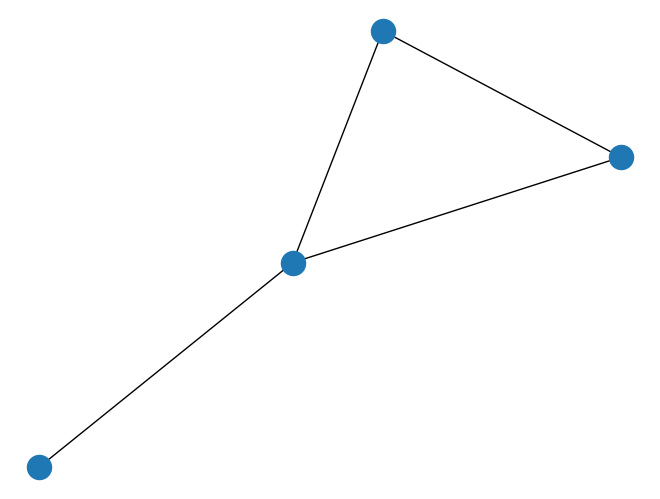

In [50]:
# Defines the graph
edges = [(0, 1), (1, 2), (2, 0), (2, 3)]
graph = nx.Graph(edges)

# Draws the graph
nx.draw(graph)
plt.show()

With the graph defined, we now create the cost and mixer Hamiltonians we will use to perform QAOA:

In [9]:
# Creates the cost and mixer Hamiltonians
cost_h, mixer_h = qaoa.min_vertex_cover(graph)

This then allows us to create a layer of the QAOA circuit:

<center>
    <img src="assets/layer.png" style="height:200px;">
</center>

In [10]:
# Creates a layer of the QAOA ansatz
def qaoa_layer(gamma, alpha):
    qaoa.cost_layer(gamma, cost_h)
    qaoa.mixer_layer(alpha, mixer_h)

We can then create the full QAOA ansatz by initializing our wires, and repeatedly applying the QAOA layer:

In [23]:
# Defines the wires
wires = graph.nodes

# Defines the device
dev = qml.device('qulacs.simulator', wires=len(wires))

# Defines the full QAOA circuit
def circuit(params, **kwargs):
    
    for w in wires:
        qml.PauliX(wires=w)
    
    qml.layer(qaoa_layer, 2, params[0], params[1])

In [24]:
# Defines the QAOA cost function
cost_function = qml.VQECost(circuit, cost_h, dev)

In [25]:
# Defines the optimization procedure

optimizer = qml.GradientDescentOptimizer()
steps = 40
params = [
    [np.random.randint(-100, 100)/100 for i in range(2)],
    [np.random.randint(-100, 100)/100 for i in range(2)]
]

for i in range(steps):
    params = optimizer.step(cost_function, params)
    print("Step {} / {}".format(i+1, steps))

print("Optimal Parameters: {}".format(params))

Step 1 / 40
Step 2 / 40
Step 3 / 40
Step 4 / 40
Step 5 / 40
Step 6 / 40
Step 7 / 40
Step 8 / 40
Step 9 / 40
Step 10 / 40
Step 11 / 40
Step 12 / 40
Step 13 / 40
Step 14 / 40
Step 15 / 40
Step 16 / 40
Step 17 / 40
Step 18 / 40
Step 19 / 40
Step 20 / 40
Step 21 / 40
Step 22 / 40
Step 23 / 40
Step 24 / 40
Step 25 / 40
Step 26 / 40
Step 27 / 40
Step 28 / 40
Step 29 / 40
Step 30 / 40
Step 31 / 40
Step 32 / 40
Step 33 / 40
Step 34 / 40
Step 35 / 40
Step 36 / 40
Step 37 / 40
Step 38 / 40
Step 39 / 40
Step 40 / 40
Optimal Parameters: [[0.33, 0.14823440665554805], [-0.4563183472249533, -0.3303971521973008]]


With the optimal parameters, we can now reconstruct the probability landscape:

In [40]:
@qml.qnode(dev)
def probability_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=wires)

probs = probability_circuit(params[0], params[1])

Finally, we can display a bar graph demonstrating the probability of measuring each bitstring:

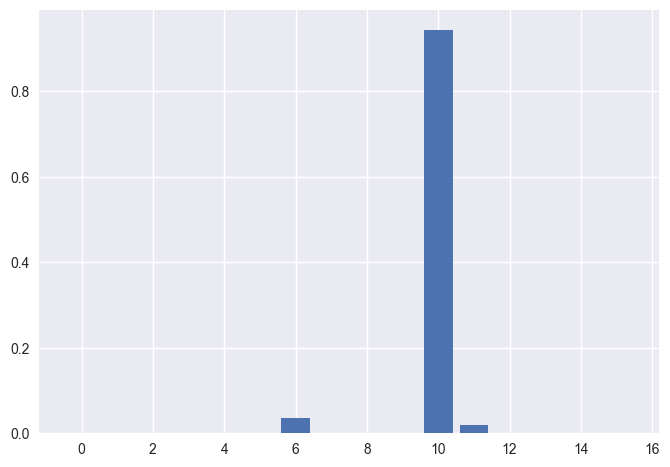

In [63]:
plt.style.use('seaborn')
plt.bar(range(2**len(wires)), probs)
plt.show()

As can be seen from this graph, the state $|10\rangle \ = \ |1010\rangle$ has the highest probability of being measured, followed by $|6\rangle \ = \ |0110\rangle$. Both of these bitstrings represent the minimum vertex covers of our graph:

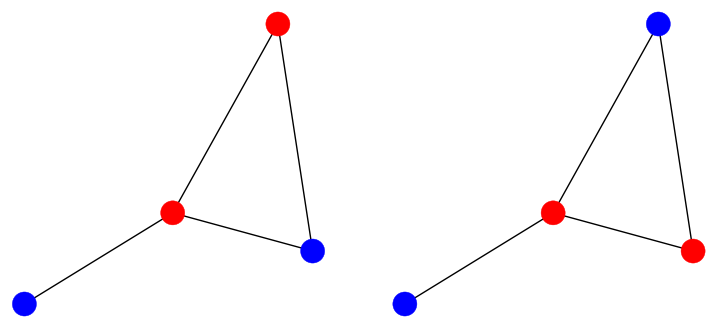

In [64]:
pos = nx.spring_layout(graph)

plt.figure(figsize=(9, 4))
plt.subplot(121)
nx.draw(graph, pos, node_color=['r', 'b', 'r', 'b'])
plt.subplot(122)
nx.draw(graph, pos, node_color=['b', 'r', 'r', 'b'])
plt.show()